In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import orthogonal_mp, Lasso

In [169]:
# Algorithm 5.1 in https://www.learningtheory.org/colt2009/papers/009.pdf
def lsc(X, y, sigma):

	# def omega_bar(t):
	# 	return t ** 2 * (t <= 1) + (2 * np.abs(t) - 1) * (t > 1)

	norm = np.linalg.norm(X, ord='fro')

	beta = 4 * sigma * sigma
	tau = 4 * sigma / norm
	T = X.shape[0]
	# h = beta / (X.shape[0] * X.shape[1])
	h = beta / (norm ** 2)

	L = np.zeros(X.shape[1])
	lambd = np.zeros_like(L)
	H = 0
	errs = []

	XX = X.T @ X
	Xy = X.T @ y
	i = 0
	while H < T:
		i+=1
		nablaV = (2 / beta) * (Xy - XX @ L)
		nablaV = nablaV - 4 * L / (tau ** 2 + L ** 2)
		L = L + h * nablaV + np.sqrt(2 * h) * np.random.normal(0, 1, L.shape)
		H = H + 1
		lambd = lambd + h * L / T
		print(np.linalg.norm(nablaV))
	return lambd / h / 2


def f(u, u0):
	return (u >= u0) * (u - u0)

def heav(u):
	return (u>=0) * 1

def lsc2(Y, D, u0, lambd, alpha=1e-3, tol=1e-3):
	DD = D.T @ D 
	DY = D.T @ Y
	if len(Y.shape) > 1:
		u = np.random.normal(0, 1, (D.shape[1], Y.shape[1]))
	else:
		u = np.random.normal(0, 1, D.shape[1])
	# s = f(np.abs(u), u0)
	s = u
	for i in range(10000):
		T = (DY - DD @ s)
		grad = T - lambd * np.sign(s) + np.sqrt(2) * np.random.normal(0, 1, s.shape)
		# u0 = u0 - alpha * T 
		# u = u - alpha * grad
		# s = f(np.abs(u), u0)
		s = s + alpha * grad
	return s






In [170]:
# n features
d = 1000
# n atoms
k = 100
# true sparsity
n_sparse = 4
# variance in data
sigma_data = 0.01

# Random dictionary with normalized atoms
D = np.random.uniform(-1, 1, (d, k))
D = D / np.linalg.norm(D, axis=0)

# sparse vector s with n_sparse sparsity
s = np.zeros(k)
s[np.random.choice(k, n_sparse, replace=False)] = np.random.uniform(-5,5,n_sparse)

# noisy measurement y
y = D @ s + np.random.normal(0, sigma_data, d)

In [172]:
%%time
lambd = 0.7
s_lsc = lsc2(y, D, u0=-np.log(0.2) / lambd, lambd=lambd, alpha=1e-3)
print(s_lsc)

[-1.30101390e-03 -2.81650558e-03  5.07335397e-04  2.74496228e-03
 -8.34372342e-04 -2.34939788e-03  2.49914252e-04 -2.25451666e-03
 -1.77025669e-03  1.74517912e-03 -1.65063547e-03  2.74553265e-04
 -1.28036731e-03 -4.85592603e-03  7.97780925e-04  3.63149683e+00
  4.95254957e-04  9.19933830e-04 -1.00427998e-03 -2.18055991e-04
 -2.11310748e-03  1.04475760e-03 -3.72325634e-04 -9.10279570e-04
  2.96354429e-03  1.55323859e-04 -2.06387005e-03 -9.68433628e-04
  2.45780149e-03 -2.54468622e-03  1.69014074e-03  2.98102039e-03
  1.56234083e-03 -1.31078229e-03 -1.11000002e-03 -1.51500237e-03
 -3.73529796e-03 -8.81418429e-04  4.47273749e-05  2.89903355e-03
  2.36953385e-03  3.50020106e-04  3.08852892e-03  4.97594987e-03
  3.05319987e-04  1.27346207e-03 -4.43585741e-04 -1.30514498e-03
  1.00067963e+00  1.95525898e-03  3.10016231e-04 -3.30507055e-03
  5.15220403e-05 -1.65145139e-03  1.80401303e-03  1.19311621e-03
 -6.65509829e-03  2.50527021e-03  2.30148513e-04  2.49471152e-03
  4.82449650e-04 -2.00513

In [173]:
%%time
clf = Lasso(alpha=1e-3)
s_lasso = clf.fit(D, y).coef_

Wall time: 2 ms


In [174]:
%%time
s_mp = orthogonal_mp(D, y, tol=1e-3)

Wall time: 35.2 ms


<StemContainer object of 3 artists>

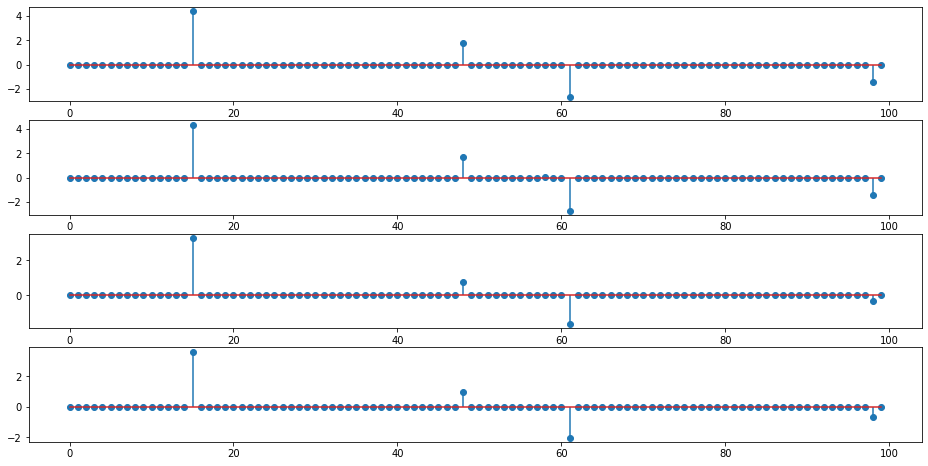

In [175]:
plt.figure(figsize=(16,8))
plt.subplot(411)
plt.stem(s, use_line_collection=True)
plt.subplot(412)
plt.stem(s_mp, use_line_collection=True)
plt.subplot(413)
plt.stem(s_lasso, use_line_collection=True)
plt.subplot(414)
plt.stem(s_lsc, use_line_collection=True)